In [1]:
import warnings
from math import exp, log, sqrt
from datetime import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from xgboost import XGBRegressor

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/yearly-water-usage.csv"
series = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

In [3]:
!mkdir data
!ls

data  sample_data


In [4]:
# split into a training and validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('data/yearly-water-usage-dataset.csv', header=False)
validation.to_csv('data/yearly-water-usage-validation.csv', header=False)

Dataset 69, Validation 10


## Persistence model as a baseline model

In [ ]:
# evaluate a persistence model
series = pd.read_csv('data/yearly-water-usage-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat[0], obs[0]))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

## Data Analysis

### Summary Statistics

In [ ]:
# summary statistics of time series
print(series.describe())

                1
count   69.000000
mean   500.478261
std     73.901685
min    344.000000
25%    458.000000
50%    492.000000
75%    538.000000
max    662.000000


### Line Plot

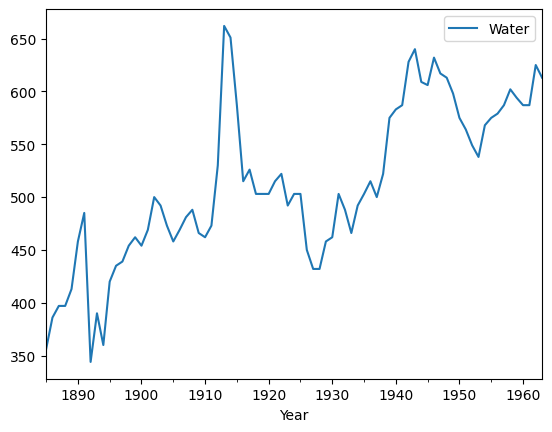

In [5]:
series.plot()
plt.show()

### Density Plot

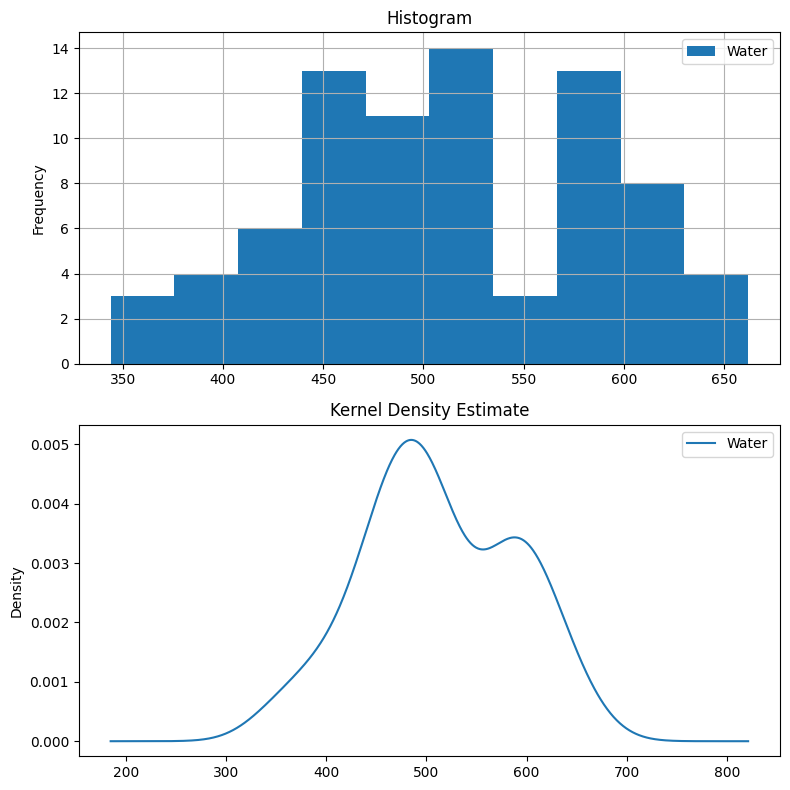

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # Create a 2-row layout

# Plot histogram on the first subplot
series.plot(kind='hist', ax=axes[0], title="Histogram")
axes[0].grid(True)

# Plot kernel density estimate (KDE) on the second subplot
series.plot(kind='kde', ax=axes[1], title="Kernel Density Estimate")

plt.tight_layout()
plt.show()

### Box and Whisker Plots

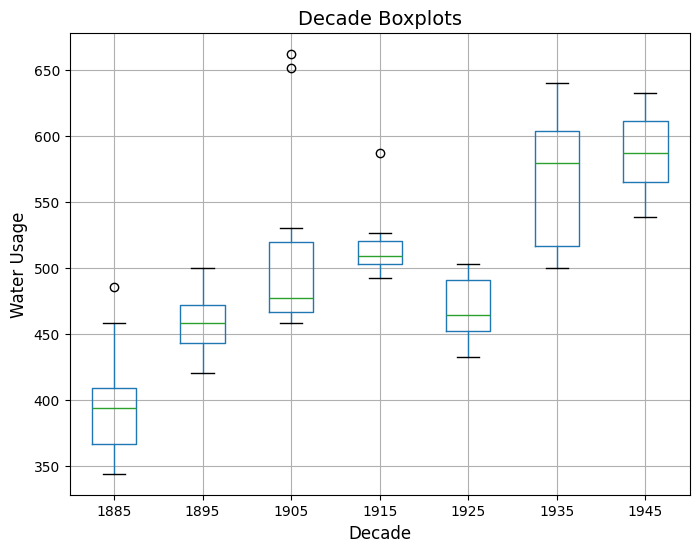

In [7]:
# Group the data by decade
groups = series.groupby(pd.Grouper(freq='10YS'))

# Create a DataFrame to store decade's values for boxplots
years = pd.DataFrame({name.year: group.squeeze().values
                      for name, group in groups
                      if len(group.values) == 10})

# Plot boxplots
fig, ax = plt.subplots(figsize=(8, 6))
years.boxplot(ax=ax)
ax.set_title("Decade Boxplots", fontsize=14)
ax.set_xlabel("Decade", fontsize=12)
ax.set_ylabel("Water Usage", fontsize=12)
ax.grid(True)
plt.show()

## SARIMAX Models

### Manually Configured SARIMAX
The results show that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and in turn that <strong>the 1-lag differenced time series is stationary</strong> or does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

In [ ]:
X = series

# Difference the data to make it stationary
stationary = X.diff().dropna() # X[i] - X[i - 1]

# Perform the Augmented Dickey-Fuller test
result = adfuller(stationary)

print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

stationary.to_csv('stationary.csv', index=True, header=False)

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


- The ACF shows a significant lags to 4 time steps.
- The PACF shows a significant lag to 1 time step.
- A good starting point for the p and q values are 4 and 1.
- This quick analysis suggests an ARIMA(4,1,1) on the raw data may be a good starting point.
- The RMSE value for this model is not less than the baseline, so a grid search might be helpful.

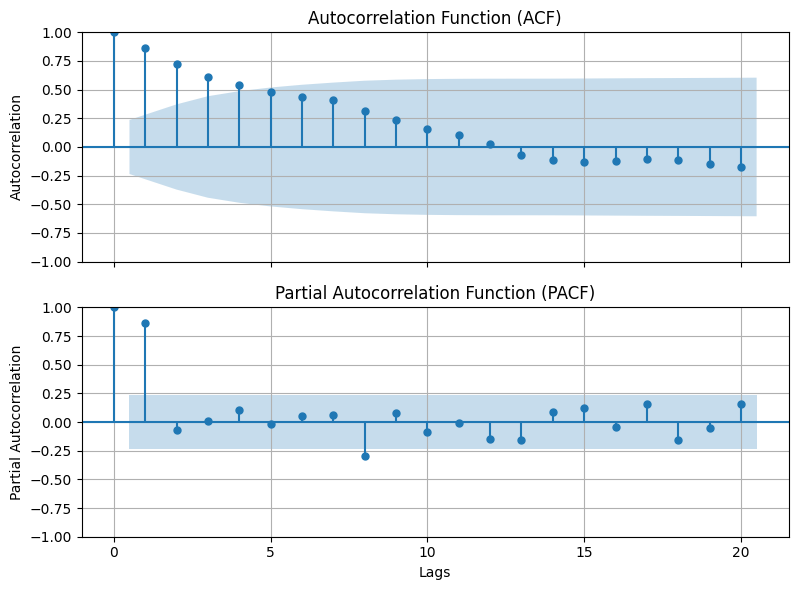

In [ ]:
# Create a figure with two subplots: one for ACF and one for PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot the ACF in the first subplot
plot_acf(series, lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

# Plot the PACF in the second subplot
plot_pacf(series, lags=20, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Split into train and test sets
X = series.values
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
p, d, q = 4, 1, 1

# Walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs[0]:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=530.101, expected=503.000
predicted=511.157, expected=503.000
predicted=515.633, expected=515.000
predicted=520.899, expected=522.000
predicted=525.009, expected=492.000
predicted=492.360, expected=503.000
predicted=504.663, expected=503.000
predicted=512.083, expected=450.000
predicted=454.314, expected=432.000
predicted=441.328, expected=432.000
predicted=452.419, expected=458.000
predicted=470.224, expected=462.000
predicted=465.859, expected=503.000
predicted=498.108, expected=488.000
predicted=483.400, expected=466.000
predicted=455.129, expected=492.000
predicted=492.321, expected=503.000
predicted=503.711, expected=515.000
predicted=505.816, expected=500.000
predicted=493.165, expected=522.000
predicted=515.483, expected=575.000
predicted=571.331, expected=583.000
predicted=568.103, expected=587.000
predicted=567.410, expected=628.000
predicted=620.639, expected=640.000
predicted=632.546, expected=609.000
predicted=594.337, expected=606.000
predicted=602.107, expected=

### Grid Search SARIMAX Hyperparameters

In [12]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = list(train)
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=arima_order, enforce_stationarity=True,
                        enforce_invertibility=False,)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=1)  # Forecast next step
        yhat = forecast[0]  # Extract the scalar value
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = range(0,4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=554.755
ARIMA(0, 0, 1) RMSE=288.590
ARIMA(0, 0, 2) RMSE=174.796
ARIMA(0, 0, 3) RMSE=108.617
ARIMA(0, 1, 0) RMSE=21.658
ARIMA(0, 1, 1) RMSE=21.627
ARIMA(0, 1, 2) RMSE=21.830
ARIMA(0, 1, 3) RMSE=23.954
ARIMA(1, 0, 0) RMSE=21.961
ARIMA(1, 0, 1) RMSE=21.930
ARIMA(1, 0, 2) RMSE=22.053
ARIMA(1, 0, 3) RMSE=24.083
ARIMA(1, 1, 0) RMSE=21.636
ARIMA(1, 1, 1) RMSE=22.671
ARIMA(1, 1, 2) RMSE=22.713
ARIMA(1, 1, 3) RMSE=24.045
ARIMA(2, 0, 0) RMSE=21.939
ARIMA(2, 0, 2) RMSE=22.112
ARIMA(2, 0, 3) RMSE=21.701
ARIMA(2, 1, 0) RMSE=21.426
ARIMA(2, 1, 1) RMSE=22.230
ARIMA(2, 1, 2) RMSE=24.581
ARIMA(2, 1, 3) RMSE=25.737
ARIMA(3, 0, 0) RMSE=21.712
ARIMA(3, 0, 1) RMSE=22.421
ARIMA(3, 0, 2) RMSE=23.719
ARIMA(3, 0, 3) RMSE=22.112
ARIMA(3, 1, 0) RMSE=23.402
ARIMA(3, 1, 1) RMSE=24.091
ARIMA(3, 1, 2) RMSE=98.927
ARIMA(3, 1, 3) RMSE=81.564
Best ARIMA(2, 1, 0) RMSE=21.426


### Review Residual Errors
The above grid search uncovered that the best parameters are p, d, q = 2, 1, 0 and below is a residual analysis for a model with these parameters.
The graphs suggest a Gaussian-like distribution with a longer right tail. This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.

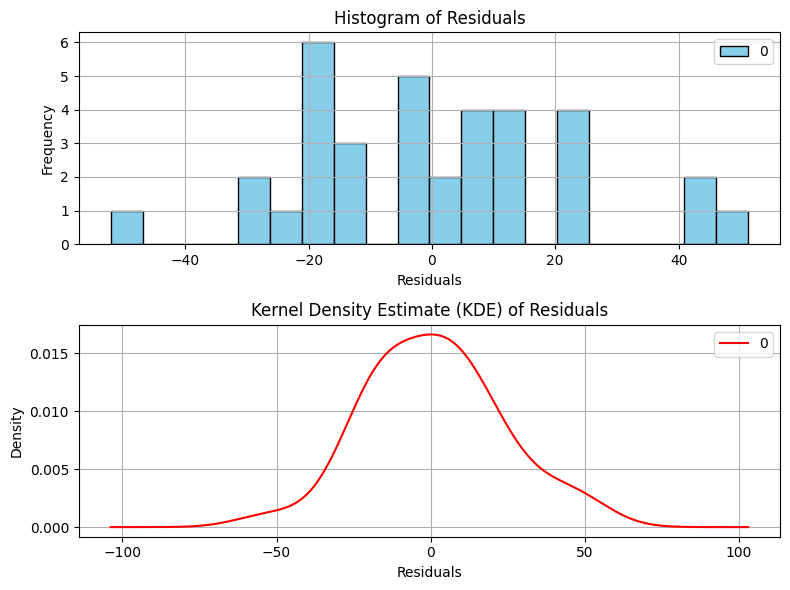

In [ ]:
# Split into train and test sets
X = series.values
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
p, d, q = 2, 1, 0 # best model after grid search

# Walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the histogram in the first subplot
residuals.plot(kind='hist', bins=20, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the KDE in the second subplot
residuals.plot(kind='kde', ax=axes[1], color='red')
axes[1].set_title('Kernel Density Estimate (KDE) of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# summary statistics of residuals
print(residuals.describe())

               0
count  35.000000
mean    1.081458
std    22.022200
min   -52.104858
25%   -16.209641
50%    -0.454834
75%    12.089066
max    51.281128


Above information is used to bias-correct predictions by adding the mean residual error of 1.081624 to each forecast made in the below cell.

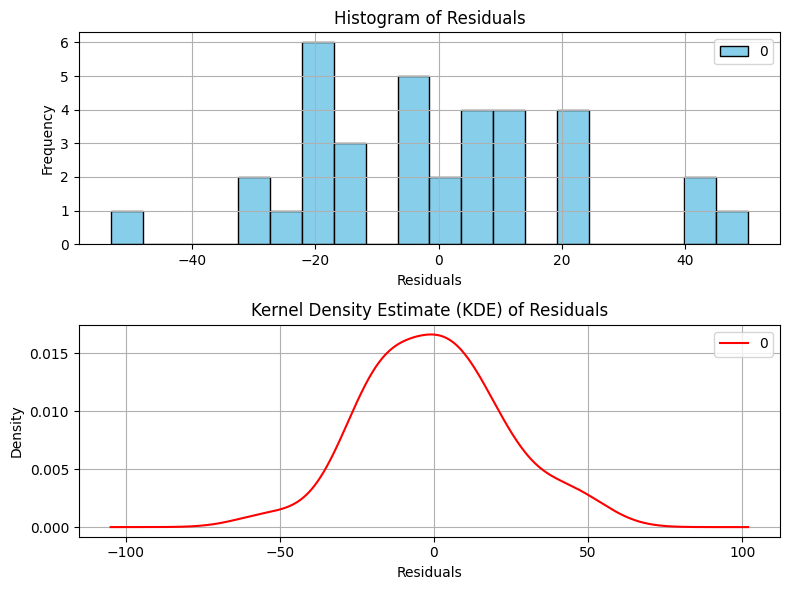

In [ ]:
# Split into train and test sets
X = series.values
X = X.astype('float32')
size = int(len(X) * 0.50)
train, test = X[:size], X[size:]

history = list(train)
predictions = []
p, d, q = 2, 1, 0 # best model after grid search

bias = 1.081458
# Walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    yhat = forecast[0]  # Extract the scalar value
    yhat += bias
    predictions.append(yhat)
    obs = test[t]  # Extract the scalar value
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot the histogram in the first subplot
residuals.plot(kind='hist', bins=20, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot the KDE in the second subplot
residuals.plot(kind='kde', ax=axes[1], color='red')
axes[1].set_title('Kernel Density Estimate (KDE) of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# summary statistics of residuals
print(residuals.describe())

               0
count  35.000000
mean    0.000003
std    22.022205
min   -53.186310
25%   -17.291092
50%    -1.536316
75%    11.007614
max    50.199646


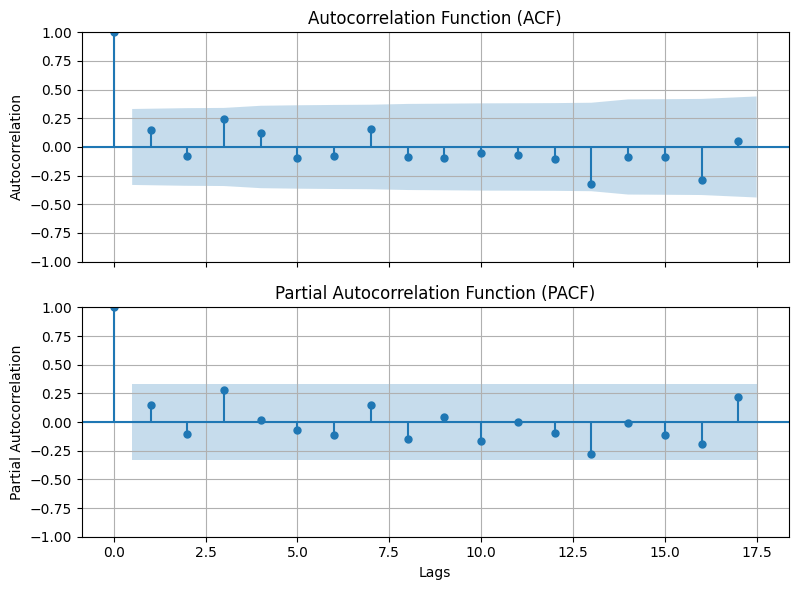

In [ ]:
# Create a figure with two subplots: one for ACF and one for PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot the ACF in the first subplot
plot_acf(residuals, lags=17, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

# Plot the PACF in the second subplot
plot_pacf(residuals, lags=17, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Model Validation

### Finalize Model
Fit the model on the whole train dataset (without spliting) after applying transformation, and save it.

In [ ]:
series = pd.read_csv('data/yearly-water-usage-dataset.csv', header=None,
                     index_col=0, parse_dates=True)

X = series.squeeze().values
X = X.astype('float32')

# fit model
# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 2, 1, 0
model = SARIMAX(X, order=(p, d, q), enforce_stationarity=True,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)
# bias constant which is the mean of residuals
bias = 1.081458
# save model
model_fit.save('forecasting_yearly_water_usage_in_baltimore.pkl')
np.save('model_bias.npy', [bias])

In [ ]:
!ls

data						   model_bias.npy  stationary.csv
forecasting_monthly_armed_robberies_in_boston.pkl  sample_data


### Make Prediction
Predict the next value and compare it with the real data (the first value in the validation dataset).

In [ ]:
# load the finalized model and make a prediction
model_fit = SARIMAXResults.load('forecasting_yearly_water_usage_in_baltimore.pkl')
bais = np.load('model_bias.npy')
forecast = model_fit.forecast(steps=1)  # Forecast next step
_ = forecast[0]  # Extract the scalar value
yhat = _ + bais
print('Predicted: %.3f' % yhat)

Predicted: 540.011


<ipython-input-33-39f22828c69d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted: %.3f' % yhat)


In [ ]:
validation = pd.read_csv('data/yearly-water-usage-validation.csv', header=None,
                         index_col=0, parse_dates=True)
validation.head(1)

,1
0,
1954-01-01,568


### Validate Model

In [ ]:

# Split into train and test sets
series = pd.read_csv('data/yearly-water-usage-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.squeeze().values  # Convert to 1D array
X = X.astype('float32')
history = list(X)
predictions = []

validation = pd.read_csv('data/yearly-water-usage-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.squeeze().values  # Convert to 1D array
y = y.astype('float32')

# load the finalized model and make first prediction
model_fit = SARIMAXResults.load('forecasting_yearly_water_usage_in_baltimore.pkl')
bias = np.load('model_bias.npy')
forecast = model_fit.forecast(steps=1)  # Forecast next step
_ = forecast[0]  # Extract the scalar value
yhat = _ + bias[0]

predictions.append(yhat)
history.append(y[0])
print(f"predicted={yhat:.3f}, expected={y[0]:.3f}")

# the best parameters achieved after grid search (but on not-transformed data)
p, d, q = 2, 1, 0
# Walk-forward validation
for t in range(1, len(y)):
    model = SARIMAX(history, order=(p, d, q), enforce_stationarity=True,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=1)  # Forecast next step
    _ = forecast[0]  # Extract the scalar value
    yhat = _ + bias[0]
    predictions.append(yhat)
    obs = y[t]  # Extract the scalar value
    history.append(obs)
    print(f"predicted={yhat:.3f}, expected={obs:.3f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(y, predictions))
print(f"Test RMSE: {rmse:.3f}")

predicted=540.011, expected=568.000
predicted=571.593, expected=575.000
predicted=573.292, expected=579.000
predicted=579.561, expected=587.000
predicted=588.064, expected=602.000
predicted=603.025, expected=594.000
predicted=593.177, expected=587.000
predicted=588.556, expected=587.000
predicted=588.796, expected=625.000
predicted=627.947, expected=613.000
Test RMSE: 16.533


<Axes: >

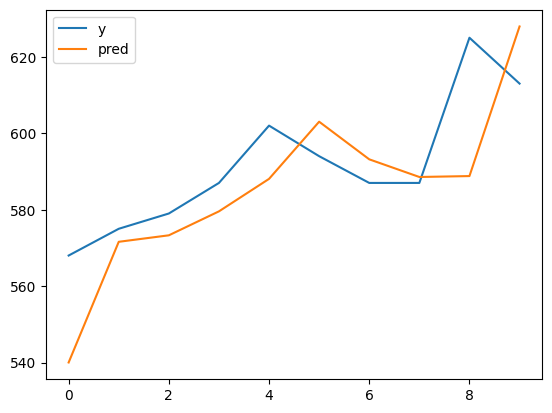

In [ ]:
y_and_pred = pd.DataFrame({'y': y, 'pred': predictions})
y_and_pred.plot()

# Predict using XGBoost 2.0 model

Using a partial grid search over only n_estimators and max_depth, the selected model has a superior result. The grid search can involve other parameters such as num_lags.

https://kaabar-sofien.medium.com/xgboost-2-0-is-here-to-improve-your-time-series-forecasts-98fd35aaca40

In [ ]:
def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))


def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)


def data_preprocessing(data, num_lags, test_len=12):
    # Prepare the data for training
    x = []
    y = []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i+ num_lags])
    # Convert the data to numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Split the data into training and testing sets
    x_train = x[:-test_len]
    y_train = y[:-test_len]
    x_test = x[-test_len:]
    y_test = y[-test_len:]

    return x_train, y_train, x_test, y_test


url = "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/yearly-water-usage.csv"
series = pd.read_csv(url, header=0, index_col=0, parse_dates=True)
series = np.reshape(series.values, (-1))
data = np.diff(series)

In [ ]:
def evaluate_xgboost_model(n_estimators, max_depth):
  # test_len = 15
  # x_train, y_train, x_test, y_test = data_preprocessing(data, 30, test_len)

  # Create the model
  model = XGBRegressor(random_state = 0, n_estimators = n_estimators, max_depth = max_depth)

  # Fit the model to the data
  model.fit(x_train, y_train)
  y_pred_xgb = model.predict(x_test)

  # inverse diff to get the real predictions
  real_preds = []
  for i in range(len(y_pred_xgb)):
      real_preds.append(y_pred_xgb[i] + series[-test_len-1+i])

  # Convert predictions to numpy array for scoring
  scores = get_scores(series[-test_len:], np.array(real_preds))
  return scores[2]


test_len = 15
x_train, y_train, x_test, y_test = data_preprocessing(data, 30, test_len)
best_score = 1000
for n_estimators in range(1,100):
    for max_depth in range(1,100):
      try:
          rmse = evaluate_xgboost_model(n_estimators, max_depth)
          if rmse < best_score:
              best_score, best_cfg = rmse, (n_estimators, max_depth)
          print('XGBoost%s RMSE=%.3f' % ((n_estimators, max_depth),rmse))
      except:
          continue
print('Best XGBoost%s RMSE=%.3f' % (best_cfg, best_score))

Streaming output truncated to the last 5000 lines.
XGBoost(49, 51) RMSE=19.188
XGBoost(49, 52) RMSE=19.188
XGBoost(49, 53) RMSE=19.188
XGBoost(49, 54) RMSE=19.188
XGBoost(49, 55) RMSE=19.188
XGBoost(49, 56) RMSE=19.188
XGBoost(49, 57) RMSE=19.188
XGBoost(49, 58) RMSE=19.188
XGBoost(49, 59) RMSE=19.188
XGBoost(49, 60) RMSE=19.188
XGBoost(49, 61) RMSE=19.188
XGBoost(49, 62) RMSE=19.188
XGBoost(49, 63) RMSE=19.188
XGBoost(49, 64) RMSE=19.188
XGBoost(49, 65) RMSE=19.188
XGBoost(49, 66) RMSE=19.188
XGBoost(49, 67) RMSE=19.188
XGBoost(49, 68) RMSE=19.188
XGBoost(49, 69) RMSE=19.188
XGBoost(49, 70) RMSE=19.188
XGBoost(49, 71) RMSE=19.188
XGBoost(49, 72) RMSE=19.188
XGBoost(49, 73) RMSE=19.188
XGBoost(49, 74) RMSE=19.188
XGBoost(49, 75) RMSE=19.188
XGBoost(49, 76) RMSE=19.188
XGBoost(49, 77) RMSE=19.188
XGBoost(49, 78) RMSE=19.188
XGBoost(49, 79) RMSE=19.188
XGBoost(49, 80) RMSE=19.188
XGBoost(49, 81) RMSE=19.188
XGBoost(49, 82) RMSE=19.188
XGBoost(49, 83) RMSE=19.188
XGBoost(49, 84) RMSE=19.1

MSE: 253.2796, MAE: 12.4063, RMSE: 15.9148


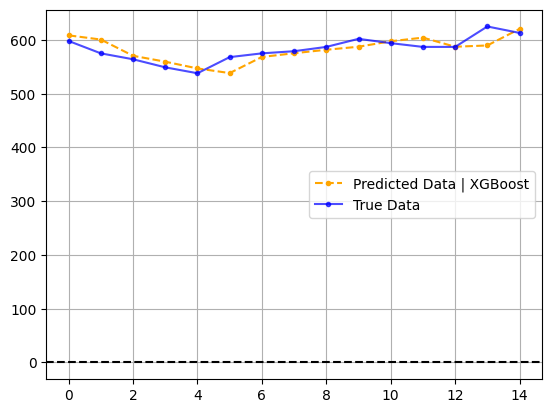

In [ ]:
test_len = 15
x_train, y_train, x_test, y_test = data_preprocessing(data, 30, test_len)

# Create the model
model = XGBRegressor(random_state = 0, n_estimators = 1, max_depth = 5)

# Fit the model to the data
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)

# inverse diff to get the real predictions
real_preds = []
for i in range(len(y_pred_xgb)):
    real_preds.append(y_pred_xgb[i] + series[-test_len-1+i])

# Plotting
plt.plot(real_preds, label='Predicted Data | XGBoost', linestyle='--',
         marker = '.', color = 'orange')
plt.plot(series[-test_len:], label='True Data', marker = '.', alpha = 0.7, color = 'blue')
plt.legend()
plt.grid()
plt.axhline(y = 0, color = 'black', linestyle = '--')

# Convert predictions to numpy array for scoring
scores = get_scores(series[-test_len:], np.array(real_preds))
print(f"MSE: {scores[0]:.4f}, MAE: {scores[1]:.4f}, RMSE: {scores[2]:.4f}")

# Predict using Amazon's time series forecasting model
Each time I run the model to predict and measure its accuracy, a different result is achieved. This is because the deep learning model requires more data and a method like cross-validation to obtain a more reliable accuracy value.

https://towardsdatascience.com/how-to-effectively-forecast-time-series-with-amazons-new-time-series-forecasting-model-9e04d4ccf67e

https://github.com/amazon-science/chronos-forecasting?tab=readme-ov-file

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-svx4pirx
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-svx4pirx
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 39515ff0fcdae55bbbf546d90193dbe54b201556
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.8 MB/s eta 0:00:00
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.4.1-py3-none-any.whl size=29154 sha256=0ddca36d3ab7c326aa669577503c52cb129ae029cab17162867aeeda02cdaa08
  Stored in directory: /tmp/pip-ephem-wheel-cache-wlxlvj3b/wheels/ba/7f/47/c8e535215a6b02669af6db36392beef76752951c59bf8b5e74
Successfully built chronos-forecasting
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1

In [ ]:
!pip install pandas
!pip install numpy
!pip install tqdm

In [ ]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm

def load_model():
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    )
    return pipeline

def predict(pipeline: ChronosPipeline, timeseries: torch.Tensor,
            prediction_length: int = 12) -> np.ndarray:
    """given a timeseries, predict with chronos model"""
    forecast = pipeline.predict(timeseries, prediction_length,
                                num_samples=1)[0][0]
                                # shape [num_series, num_samples, prediction_length]
    return forecast

def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)

series = pd.read_csv('data/yearly-water-usage-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.to_numpy()
X = X.reshape(-1)

validation = pd.read_csv('data/yearly-water-usage-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.to_numpy()
y = y.reshape(-1)

pipeline = load_model()
predictions = []
X_list = X.tolist()
y_list = y.tolist()
for i, obs in tqdm(enumerate(y), total=len(y)):
    forecast = predict(pipeline, torch.tensor(X_list), prediction_length=1)
    predictions.append(forecast.tolist()[0])
    X_list.append(obs)

# Convert predictions to numpy array for scoring
scores = get_scores(y, np.array(predictions))
print(f"MSE: {scores[0]:.4f}, MAE: {scores[1]:.4f}, RMSE: {scores[2]:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

MSE: 903.3285, MAE: 26.9541, RMSE: 30.0554


<Axes: >

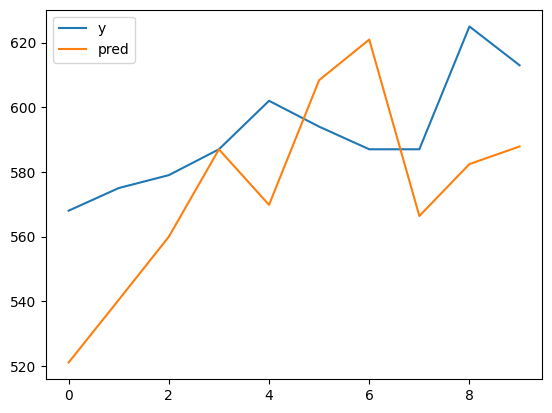

In [ ]:
y_and_pred = pd.DataFrame({'y': y, 'pred': predictions})
y_and_pred.plot()

In [ ]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from tqdm.auto import tqdm

def load_model():
    pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
    )
    return pipeline

def predict(pipeline: ChronosPipeline, timeseries: torch.Tensor,
            prediction_length: int = 12) -> np.ndarray:
    """given a timeseries, predict with chronos model"""
    forecast = pipeline.predict(timeseries, prediction_length,
                                num_samples=1)[0][0]
                                # shape [num_series, num_samples, prediction_length]
    return forecast

def get_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)
def get_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def get_rmse(y_true, y_pred):
    return np.sqrt(get_mse(y_true, y_pred))

def get_scores(y_true, y_pred):
    """given true and predicted values, return mse, mae, rmse"""
    return get_mse(y_true, y_pred), get_mae(y_true, y_pred), get_rmse(y_true, y_pred)

series = pd.read_csv('data/yearly-water-usage-dataset.csv', header=None,
                     index_col=0, parse_dates=True)
X = series.to_numpy()
X = X.reshape(-1)

validation = pd.read_csv('data/yearly-water-usage-validation.csv', header=None,
                         index_col=0, parse_dates=True)
y = validation.to_numpy()
y = y.reshape(-1)

pipeline = load_model()
predictions = []
X_list = X.tolist()
y_list = y.tolist()

# now test the model. Given the last x values, predict the next y values,
# then we can calculate metrics like MSE, RMSE, MAE
CONTEXT_LENGTH = 106
PREDICTION_LENGTH = 1

X = X_list + y_list
mse_scores, mae_scores, rmse_scores = [], [], []
for i in tqdm(range(0, len(X))):
    print('i: ', i)
    if (i+CONTEXT_LENGTH+PREDICTION_LENGTH) > len(X):
        print('break')
        break
    prediction = predict(pipeline, torch.tensor(X[i:i+CONTEXT_LENGTH]), PREDICTION_LENGTH)
    ground_truth = X[i+CONTEXT_LENGTH:i+CONTEXT_LENGTH+PREDICTION_LENGTH]

    mse, mae, rmse = get_scores(ground_truth, prediction.numpy())
    mse_scores.append(mse), mae_scores.append(mae), rmse_scores.append(rmse)

  0%|          | 0/79 [00:00<?, ?it/s]

i:  0
break
